In [70]:
% matplotlib inline

import numpy as np
import pandas as pd
import pyprind

from collections import Counter
from math import log
from matplotlib import pyplot as plt
from os.path import exists
from sklearn.linear_model import LinearRegression

# Exercise: Financial Data

1. Get the Data: Go to Yahoo! Finance and download daily data from a stock that has at least eight years of data, making sure it goes from earlier to later. If you don’t know how to do it, Google it.
2. Create the time series of daily log returns of the stock price.
3. Just for comparison, do the same for volume data (i.e., create the time series of daily log changes in volume).
4. Next, try to set up a linear regression model that uses the past two returns to predict the next return. Run it and see if you can make any money with it. Try it for both stock returns and volumes. Bonus points if you: do a causal model, normalize for volatility (standard deviation), or put in an exponential decay for old data.
5. Draw the cumulative P&L (forecast × realized) graphs and see if they drift up.

## Let's go!

* Get the Data: Go to Yahoo! Finance and download daily data from a stock that has at least eight years of data, making sure it goes from earlier to later. If you don’t know how to do it, Google it.

In [23]:
data_path_decreasing = 'dds_datasets/dds_ch6_stock_value-orange-decreasing.csv'
data_path = 'dds_datasets/dds_ch6_stock_value-orange.csv'

def reformat_data(data_path_decreasing, data_path):
    '''Write data in increasing order.'''
    with open(data_path_decreasing, 'r') as fp:
        lines = []
        for index, line in enumerate(fp):
            if index == 0:
                header = line
            else:
                lines.append(line)
    lines.reverse()
    with open(data_path, 'w') as fw:
        fw.write(header)
        for line in lines:
            fw.write(line)

if not exists(data_path):
    reformat_data(data_path_decreasing, data_path)
    


In [24]:
data_df = pd.read_csv(data_path)

In [25]:
data_df.head(n=5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2000-01-03,133.2,136.2,130.5,131.0,1551400,54.636
1,2000-01-04,130.4,130.5,121.0,124.0,1988700,51.716
2,2000-01-05,116.0,121.8,116.0,118.0,2677400,49.214
3,2000-01-06,118.0,120.6,111.1,116.0,2847200,48.380
4,2000-01-07,113.1,120.6,112.5,119.5,1593200,49.840


In [26]:
data_df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,4336.000000,4336.000000,4336.000000,4336.000000,4.336000e+03,4336.000000
mean,26.906441,27.374014,26.427643,26.881904,9.116170e+06,13.808862
std,31.697064,32.535892,30.901294,31.673224,5.886672e+06,12.422609
min,7.120000,7.147000,6.750000,6.940000,0.000000e+00,3.041000
25%,14.220000,14.373750,14.032500,14.197500,5.790500e+06,8.920250
50%,17.852500,18.080000,17.640000,17.815000,8.175000e+06,10.265500
75%,22.480000,22.725000,22.200000,22.452500,1.120032e+07,12.522250
max,211.000000,219.000000,205.000000,219.000000,8.841360e+07,91.338000


In [27]:
data_df.shape

(4336, 7)

In [28]:
stock_close = data_df[['Date','Close']]
adj_close = data_df[['Date','Adj Close']]
volume_close = data_df[['Date','Volume']]

* Create the time series of daily log returns of the stock price.

> We typically don’t consider percent returns, but rather log returns: if Ft denotes a close on day t, then the log return that day is defined as log(Ft/F\_(t−1)) , whereas the percent return would be computed as 100((Ft/F\_(t−1)) − 1).

In [29]:
def log_return(ft, ft_1):
    if float(ft_1) == 0.0 or float(ft) == 0:
        return 'NaN'
    else:
        return log(ft / ft_1)



In [30]:
stock_close['Log Return'] = stock_close['Close']
stock_close.head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Date,Close,Log Return
0,2000-01-03,131.0,131.0
1,2000-01-04,124.0,124.0
2,2000-01-05,118.0,118.0
3,2000-01-06,116.0,116.0
4,2000-01-07,119.5,119.5


In [31]:
def create_log_return(df, column_name):
    for index, row in df.iterrows(): 
        if index > 0:
            if index % 1000 == 0:
                print(index, '...')
            try:
                log_return_value = log_return(previous_row[column_name], row[column_name])
                df.set_value(index, 'Log Return', log_return_value)
            except ZeroDivisionError:
                pass
        previous_row = row
    df.drop(0, inplace=True)  # remove first day which has no log return value

In [32]:
create_log_return(stock_close, 'Close')
create_log_return(adj_close, 'Adj Close')
stock_close.head()

1000 ...
2000 ...
3000 ...
4000 ...


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1000 ...
2000 ...
3000 ...
4000 ...


,Date,Close,Log Return
1,2000-01-04,124.0,0.054916
2,2000-01-05,118.0,0.049597
3,2000-01-06,116.0,0.017094
4,2000-01-07,119.5,-0.029726
5,2000-01-10,121.7,-0.018243


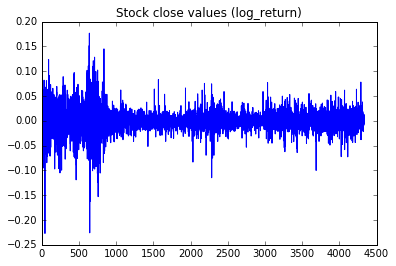

In [33]:
plt.plot(range(len(stock_close['Log Return'])), stock_close['Log Return'], color='blue')
plt.title('Stock close values (log_return)')

* Just for comparison, do the same for volume data (i.e., create the time series of daily log changes in volume).

In [34]:

volume_close = data_df[['Date','Volume']]
create_log_return(volume_close, 'Volume')

/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1000 ...
2000 ...
3000 ...
4000 ...


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
volume_close.head()

,Date,Volume,Log Return
1,2000-01-04,1988700,-0.248323
2,2000-01-05,2677400,-0.297365
3,2000-01-06,2847200,-0.061490
4,2000-01-07,1593200,0.580591
5,2000-01-10,1358000,0.159732


In [36]:
volume_log = volume_close['Log Return']
stock_log = stock_close['Log Return']
adj_log = adj_close['Log Return']

* Next, try to set up a linear regression model that uses the past two returns to predict the next return. Run it and see if you can make any money with it. Try it for both stock returns and volumes. 

Bonus points if you: do a causal model, normalize for volatility (standard deviation), or put in an exponential decay for old data.

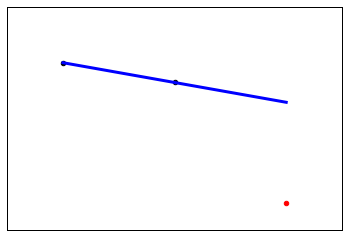

(array([-0.02718357]), array([-0.005319]), 0.06023499999999999)

In [37]:
def make_prediction(y_slice, y_target, plot=False):
    slice_size = len(y_slice)
    x_target = slice_size + 1
    X_train = [[x + 1] for x in range(slice_size)]
    regr = LinearRegression()
    regr.fit(X_train, y_slice)
    coef = regr.coef_
    intercept = regr.intercept_
    if plot:
        plt.scatter(X_train, y_slice,  color='black')
        X_plot = [[x + 1] for x in range(slice_size + 1)]
        plt.plot(X_plot, regr.predict(X_plot), color='blue', linewidth=3)
        plt.scatter([x_target], [y_target],  color='red')
        plt.xticks(())
        plt.yticks(())
        plt.show()
    
    return (y_target - regr.predict(x_target), coef, intercept)

slice = [0.054916, 0.049597]
target = [0.017094433359300037]
make_prediction(slice, target, True)

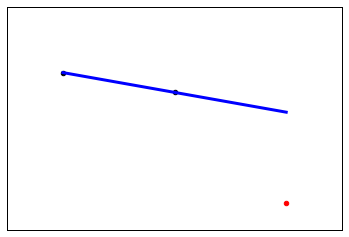

(array([-0.02452407]), array([-0.005319]), 0.057575499999999988)

In [41]:
def make_prediction_normalized(y_slice, y_target, plot=False):
    slice_size = len(y_slice)
    x_target = slice_size + 1
    slice_sd = np.std(y_slice) # normalization
    y_slice = [x - slice_sd for x in y_slice] # normalization
    X_train = [[x + 1] for x in range(slice_size)]
    regr = LinearRegression()
    regr.fit(X_train, y_slice)
    coef = regr.coef_
    intercept = regr.intercept_
    if plot:
        plt.scatter(X_train, y_slice,  color='black')
        X_plot = [[x + 1] for x in range(slice_size + 1)]
        plt.plot(X_plot, regr.predict(X_plot), color='blue', linewidth=3)
        plt.scatter([x_target], [y_target],  color='red')
        plt.xticks(())
        plt.yticks(())
        plt.show()
    
    return (regr.predict(x_target), coef, intercept)

slice = [0.054916, 0.049597]
target = [0.017094433359300037]
make_prediction_normalized(slice, target, True)

In [55]:
def money_making(log_return_values, window_size=2, invest_threshold=0.0, pred_type='usual'):
    actions = []
    log_earnings = 0
    for index, value in enumerate(log_return_values):
        if index >= window_size:
            temp = log_return_values[:index]
            slice = temp[-window_size:]
            target = value
            last_close = slice.values[-1]
            if pred_type == 'usual':
                close_pred, coeff, intercept = make_prediction(slice, target)
            elif pred_type == 'normalized':
                close_pred, coeff, intercept = make_prediction_normalized(slice, target)
            if close_pred - last_close > invest_threshold:
                money = target - last_close
                log_earnings += money
                if target > last_close:
                    actions.append('win')
                else:
                    actions.append('lose')
            else:
                if target > last_close:
                    actions.append('would have won')
                else:
                    actions.append('would have lost')
    return (Counter(actions), log_earnings)

In [71]:
def tactical_test(pred_type, upper_bound, invest_threshold, display=False):
    earnings_trace = []
    bar = pyprind.ProgBar(upper_bound - 2)
    for window_size in range(2, upper_bound):
        values = stock_log
        actions, log_earnings = money_making(values, window_size=window_size, invest_threshold=invest_threshold, pred_type=pred_type)
        try:
            earnings_trace.append(log_earnings)
            if display:
                print('Our results on CLOSE VALUES ({}):\n\tActions: {}\n\tLog earnings: {}'.format(window_size, actions, log_earnings))
        except TypeError:
            earnings_trace.append(0)
            if display:
                print('Our results on CLOSE VALUES ({}):\n\tActions: {}\n\tLog earnings: {}'.format(window_size, actions, 0))
        bar.update()
    return earnings_trace

0%                         100%
[#############################] | ETA: 00:00:00
Total time elapsed: 00:01:23


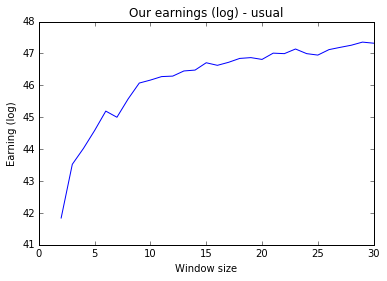

In [72]:
pred_type = 'usual'
upper_bound = 31
invest_threshold = 0.001

earnings_trace = tactical_test(pred_type, upper_bound, invest_threshold)

plt.xlabel('Window size')
plt.ylabel('Earning (log)')
plt.title('Our earnings (log) - {}'.format(pred_type))
plt.plot(range(2, upper_bound), earnings_trace)

0%                         100%
[#############################] | ETA: 00:00:00
Total time elapsed: 00:01:52


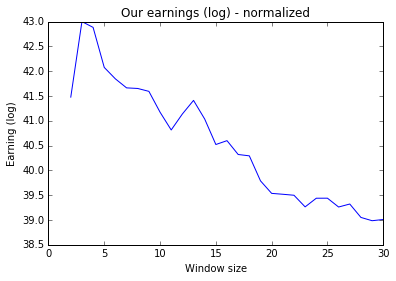

In [73]:
pred_type = 'normalized'
upper_bound = 31
invest_threshold = 0.001

earnings_trace = tactical_test(pred_type, upper_bound, invest_threshold)

plt.xlabel('Window size')
plt.ylabel('Earning (log)')
plt.title('Our earnings (log) - {}'.format(pred_type))
plt.plot(range(2, upper_bound), earnings_trace)

* Draw the cumulative P&L (forecast × realized) graphs and see if they drift up.

In [123]:
def create_pnl_demeaned(df, column_name):
    pnls = []
    for index, row in df.iterrows(): 
        if index > 0:
            if index % 1000 == 0:
                print(index, '...')
            pnl_value = row[column_name] - previous_row[column_name]
            pnls.append(pnl_value)
            df.set_value(index, 'pnl_demeaned', pnl_value)
        previous_row = row
    df.drop(0, inplace=True)  # remove first day which has no pnl value
    pnl_mean = np.mean(pnls)
    df['pnl_demeaned'] = df['pnl_demeaned'].map(lambda x: (x - pnl_mean))
    return df


In [124]:
pnl_df = data_df[['Date', 'Close']]

In [125]:
pnl_df = create_pnl_demeaned(pnl_df, 'Close')

/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1000 ...
2000 ...
3000 ...
4000 ...


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [126]:
pnl_df.head()

,Date,Close,pnl_demeaned
1,2000-01-04,124.0,-6.972901
2,2000-01-05,118.0,-5.972901
3,2000-01-06,116.0,-1.972901
4,2000-01-07,119.5,3.527099
5,2000-01-10,121.7,2.227099


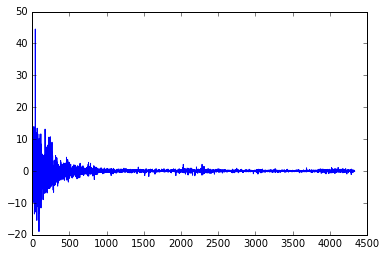

In [128]:
plt.plot(range(len(pnl_df['pnl_demeaned'])), pnl_df['pnl_demeaned'])

In [127]:
pnl_df.shape

(4335, 3)